## Transpiler Passes

Transpiler passes are classified into one of two classes: Analysis passes and Transformation passes. Passes in general work with the Directed Acyclic Graph (DAG) **TODO: insert link here** and the `property_set`, a dictionary-like object for storing properties determined by analysis passes. Analysis passes work with the DAG, but are not allowed to modify it. This contrasts with transformation passes, which do modify the DAG, and can read (but not write to) `property_set`. 

## Internals

**TODO: put something here, but I do not know what**

## Pauli Twirling

As an example we construct a transpiler pass that adds Pauli twirls. Pauli twirling is an error suppression strategy that randomizes how the qubits experience noisy channels, which we assume to be two-qubit gates below (because they are much more error-prone than single-qubit gates). However, the Pauli twirls do not effect the actual operation of the two-qubit gate, they are chosen such that those applied *before* the two-qubit gate (to the left) are countered by those applied *after* the two-qubit gate (to the right). In this sense, the two-qubit operations are identical but the way they are performed is different. One benefit of Pauli twirling is that it turns coherent errors into stochastic errors, which can be improved by averaging more.

Transpiler passes act on the DAG (directed acyclic graph **TODO: include link**), and the important method to override is `.run()`, which takes the DAG as the input. Here we will also add the initialization of pairs of Paulis that preserve the operation of each two-qubit gate. This is done with the helped method `build_twirl_set` that goes through each two-qubit Pauli (as obtained from `pauli_basis(2)`) and finding the other Pauli that preserves the operation. 

From the DAG we can collect runs/nodes (**TODO: what really is the difference between these**), which provides the set of every gate with a given name in the DAG. **TODO: what other ways can you search, like `.bfs_successors` and such? Does this belong here or in the DAG doc?**. Here, we wish to replace each node, representing an instruction, with a subcircuit which we build as a mini DAG. The mini DAG has a two-qubit quantum register added to it, and operations are added here with `apply_operation_back`, which places the `Instruction` on the output of the mini DAG (whereas `apply_operation_front` would place it on the input of the mini DAG). The node is then substituted by the mini DAG with `substitute_node_with_dag`, and the process continues over each instance of `CXGate` and `ECRGate` in the DAG (corresponding to the two-qubit basis gates on IBM backends).

In [1]:
from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit import Gate, QuantumCircuit, QuantumRegister
from qiskit.circuit.library import CXGate, ECRGate
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.quantum_info import Operator, pauli_basis

import numpy as np

from typing import Iterable, Optional

In [2]:
class PauliTwirl(TransformationPass):
    """Add Pauli twirls to two-qubit gates."""

    def __init__(
        self,
        gates_to_twirl: Optional[Iterable[Gate]] = None,
    ):
        """
        Args:
            gates_to_twirl: Names of gates to twirl. The default behavior is to twirl all
                two-qubit basis gates.
        """
        if gates_to_twirl is None:
            gates_to_twirl = [CXGate(), ECRGate()]
        self.gates_to_twirl = gates_to_twirl
        self.build_twirl_set()
        super().__init__()

    def build_twirl_set(self):
        self.twirl_set = {}
        for twirl_gate in self.gates_to_twirl:
            twirl_list = []
            for pauli_left in pauli_basis(2):
                for pauli_right in pauli_basis(2):
                    if (Operator(pauli_left) @ Operator(twirl_gate)).equiv(Operator(twirl_gate) @ pauli_right):
                        twirl_list.append((pauli_left, pauli_right))

            self.twirl_set[twirl_gate.name] = twirl_list

    def run(
        self,
        dag: DAGCircuit,
    ) -> DAGCircuit:
        for twirl_gate in self.gates_to_twirl:
            for run in dag.collect_runs(twirl_gate.name):
                for node in run:
                    pidx = np.random.randint(0, len(self.twirl_set[twirl_gate.name]),)
                    mini_dag = DAGCircuit()
                    register = QuantumRegister(2)

                    mini_dag.add_qreg(register)
                    mini_dag.apply_operation_back(self.twirl_set[twirl_gate.name][pidx][0].to_instruction(), [register[0], register[1]])
                    mini_dag.apply_operation_back(node.op, [register[0], register[1]])
                    mini_dag.apply_operation_back(self.twirl_set[twirl_gate.name][pidx][1].to_instruction(), [register[0], register[1]])
                    dag.substitute_node_with_dag(node, mini_dag)

        return dag

Consider a simple circuit with `cx`s and `ecr`s.

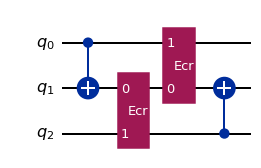

In [3]:
qc = QuantumCircuit(3)
qc.cx(0, 1)
qc.ecr(1, 2)
qc.ecr(1, 0)
qc.cx(2, 1)
qc.draw('mpl', style='iqp')

Since we are applying a single pass, we can use the shorthand for `PassManager(PauliTwirl()).run(qc)` to generate 50 randomized circuits. 

In [4]:
twirled_qcs = [PauliTwirl()(qc) for _ in range(50)]

We can see that each two-qubit gate is now sandwiched between two Paulis.

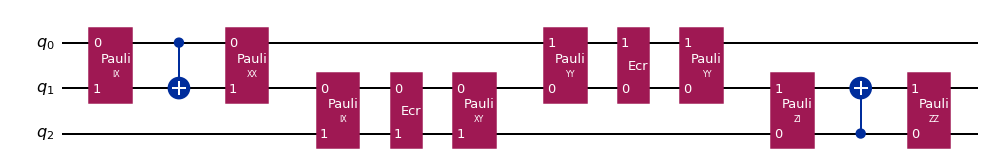

In [5]:
twirled_qcs[-1].decompose(reps=0).draw('mpl', style='iqp')

And confirming that the operators are actually the same using `Operator` from `qiskit.quantum_info`.

In [6]:
np.alltrue([Operator(twirled_qc).equiv(qc) for twirled_qc in twirled_qcs])

True